In [ ]:
import os
HOME = os.getcwd()
from ultralytics import YOLO
from IPython.display import display, Image

/content


### YOLOV8



## Custom Training

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/yolov8/

/content/drive/MyDrive/yolov8


In [ ]:
!ls

data.yaml  Licplatesdetection_train.csv    runs  train	      yolov8s.pt
labels	   Licplatesrecognition_train.csv  test  train.cache


In [ ]:
import pandas as pd
import os
import cv2
import shutil

# Paths
coordinates_csv = "/content/drive/MyDrive/yolov8/Licplatesdetection_train.csv"
images_dir = "/content/drive/MyDrive/yolov8/img"
train_dir = "/content/drive/MyDrive/yolov8/images/train"
val_dir = "/content/drive/MyDrive/yolov8/images/val"
label_train_dir = "/content/drive/MyDrive/yolov8/labels/train"
label_val_dir = "/content/drive/MyDrive/yolov8/labels/val"

# Create necessary directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(label_train_dir, exist_ok=True)
os.makedirs(label_val_dir, exist_ok=True)

# Read coordinates CSV
coordinates_df = pd.read_csv(coordinates_csv)

# Split the dataset into training and validation sets
train_df = coordinates_df.sample(frac=0.8, random_state=42)
val_df = coordinates_df.drop(train_df.index)

def convert_and_save(df, img_set_dir, label_set_dir):
    for _, row in df.iterrows():
        filename = row['img_id']
        ymin, xmin, ymax, xmax = row['ymin'], row['xmin'], row['ymax'], row['xmax']

        # Load image to get its dimensions
        img_path = os.path.join(images_dir, filename)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image: {img_path}")
            continue
        height, width = img.shape[:2]

        # Normalize coordinates
        x_center = (xmin + xmax) / 2.0 / width
        y_center = (ymin + ymax) / 2.0 / height
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height

        # YOLO format: <class_id> <x_center> <y_center> <width> <height>
        yolo_format = f"0 {x_center} {y_center} {bbox_width} {bbox_height}"

        # Save to label file
        label_path = os.path.join(label_set_dir, os.path.splitext(filename)[0] + ".txt")
        with open(label_path, 'w') as f:
            f.write(yolo_format + '\n')

        # Copy image to the respective directory
        shutil.copy(img_path, img_set_dir)

# Convert and save for training set
convert_and_save(train_df, train_dir, label_train_dir)

# Convert and save for validation set
convert_and_save(val_df, val_dir, label_val_dir)

# Create the data.yaml file
data_yaml = """
train: /content/drive/MyDrive/yolov8/images/train
val: /content/drive/MyDrive/yolov8/images/val

nc: 1
names: ['license_plate']
"""

with open("/content/drive/MyDrive/yolov8/data.yaml", 'w') as f:
    f.write(data_yaml)


In [ ]:
%cd /content/drive/MyDrive/yolov8/

!yolo task=detect mode=train model=yolov8s.pt data= /content/drive/MyDrive/yolov8/data.yaml epochs=25 imgsz=224 plots=True

/content/drive/MyDrive/yolov8
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/drive/MyDrive/yolov8/data.yaml, epochs=25, patience=50, batch=16, imgsz=224, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, in

In [ ]:
!ls runs/detect/train/

args.yaml  weights


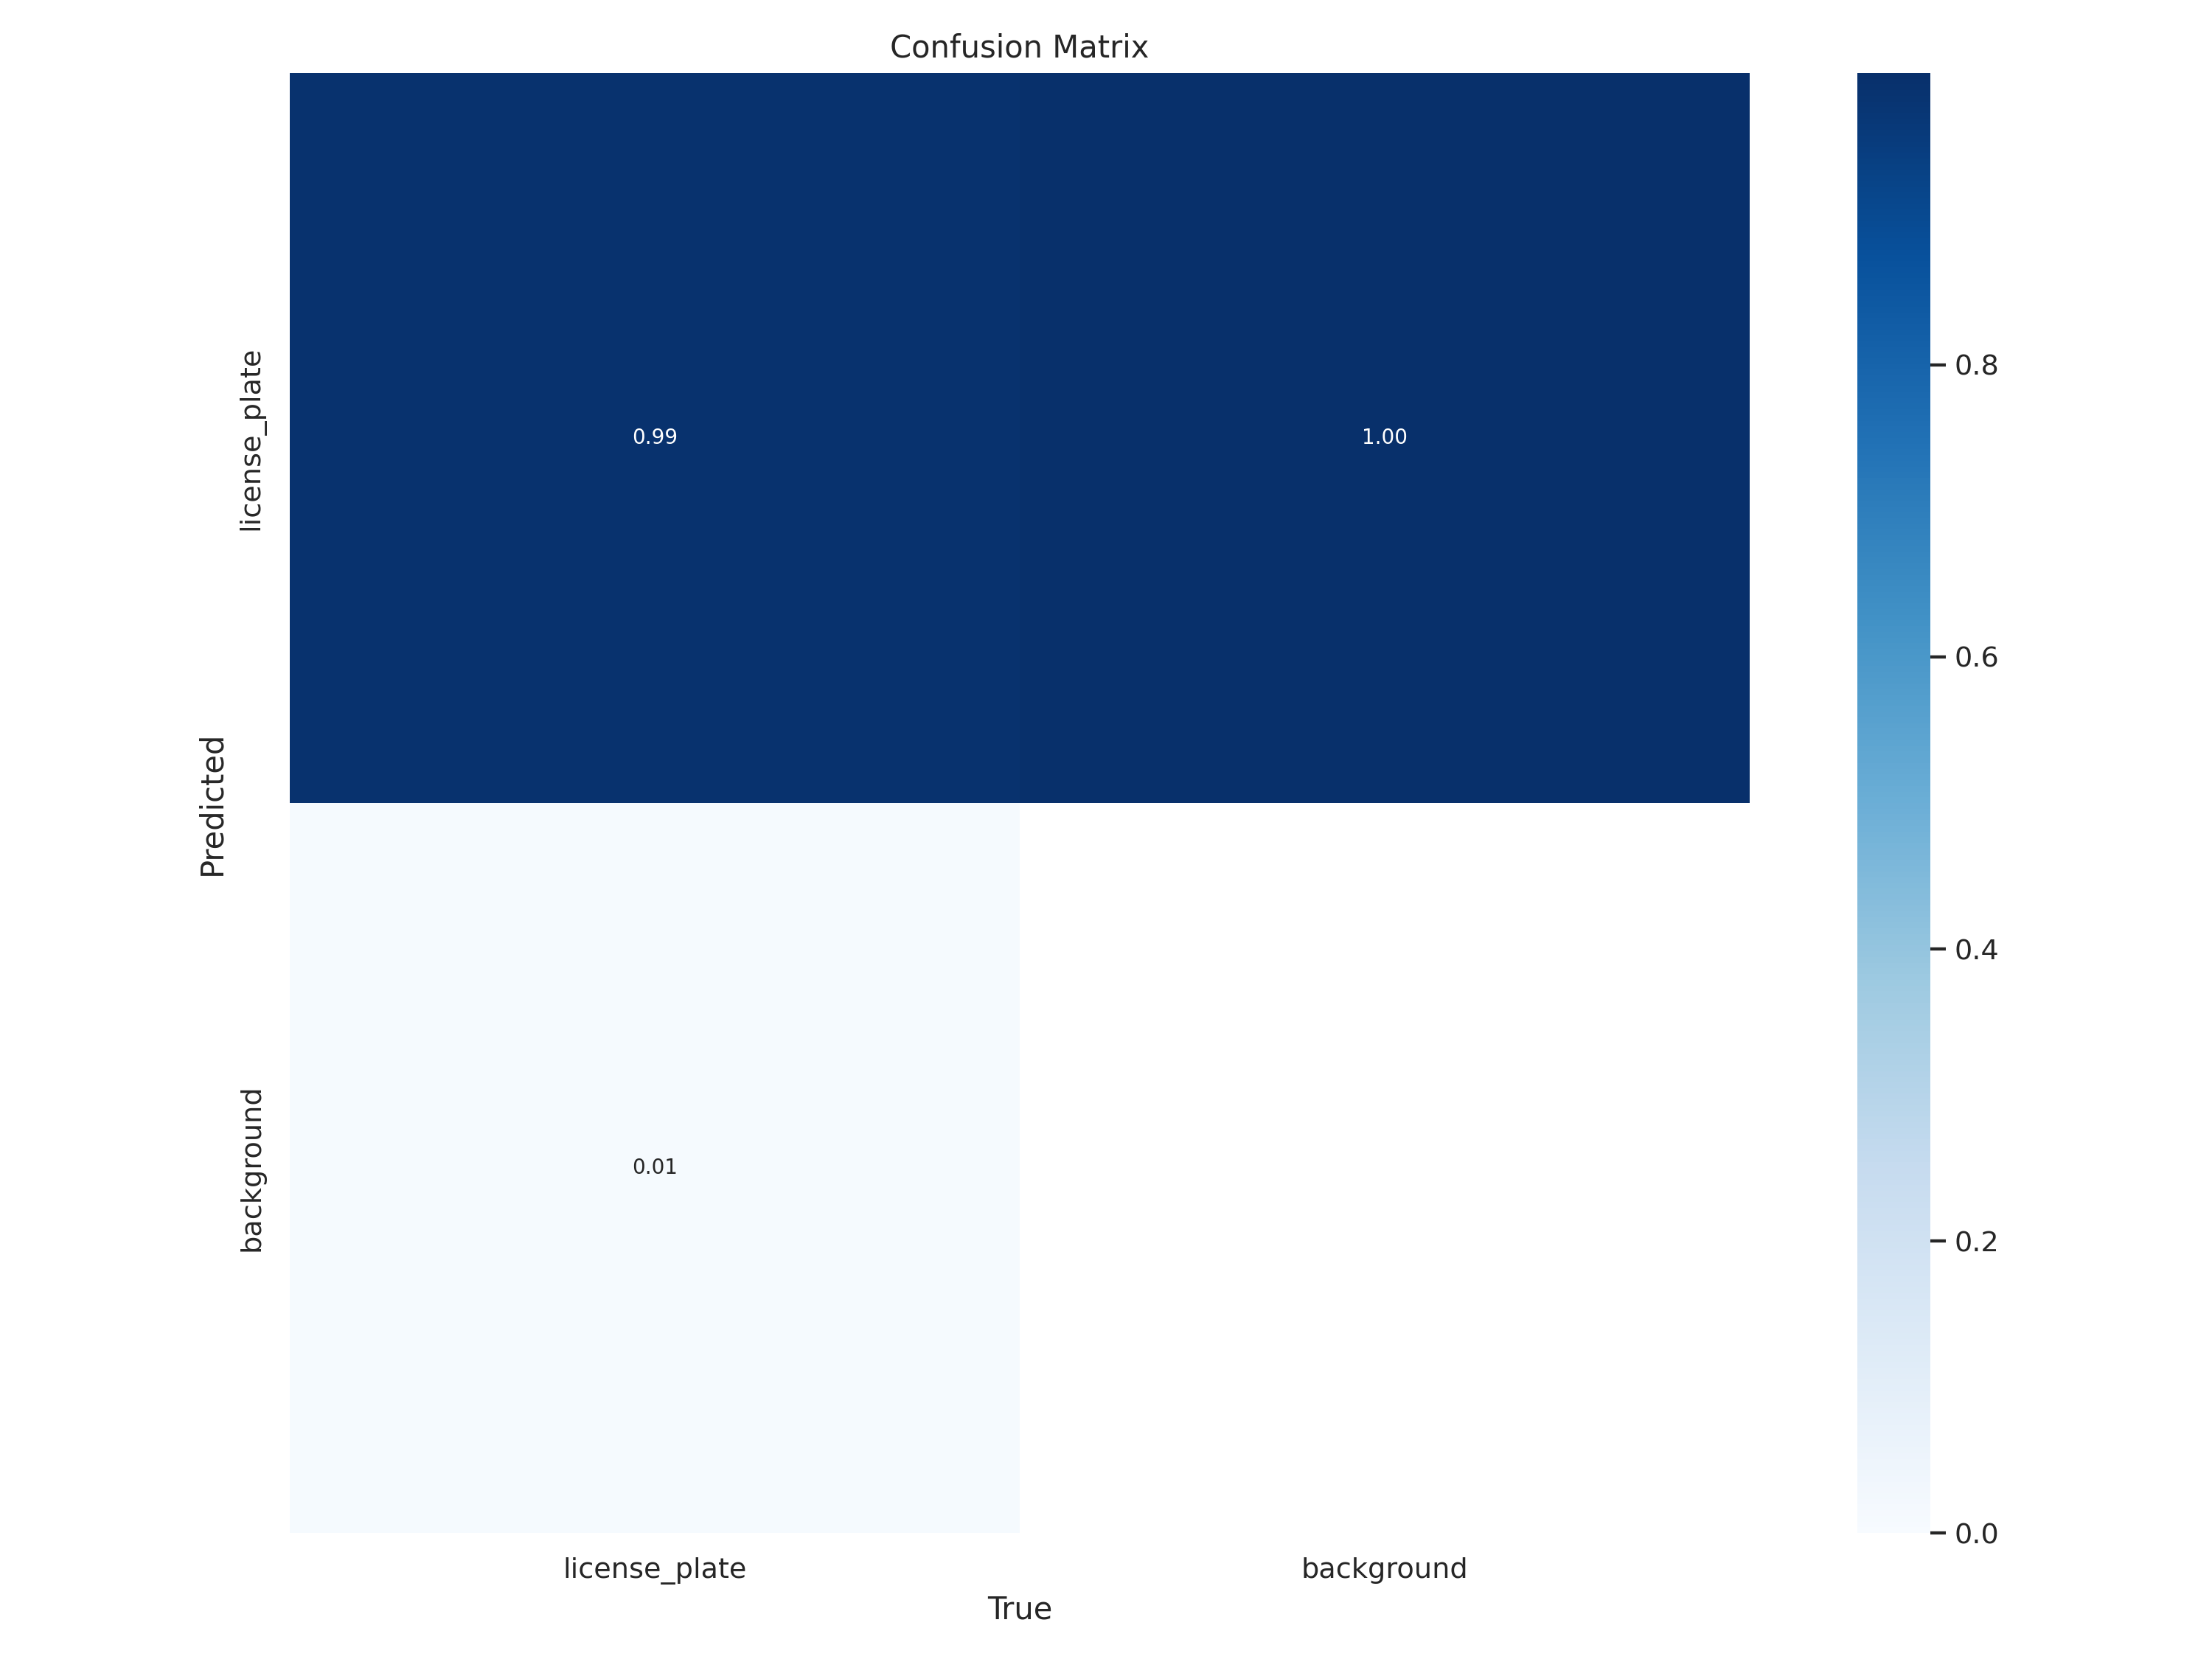

In [ ]:
Image(filename='/content/drive/MyDrive/yolov8/runs/detect/train9/confusion_matrix.png', width=600)

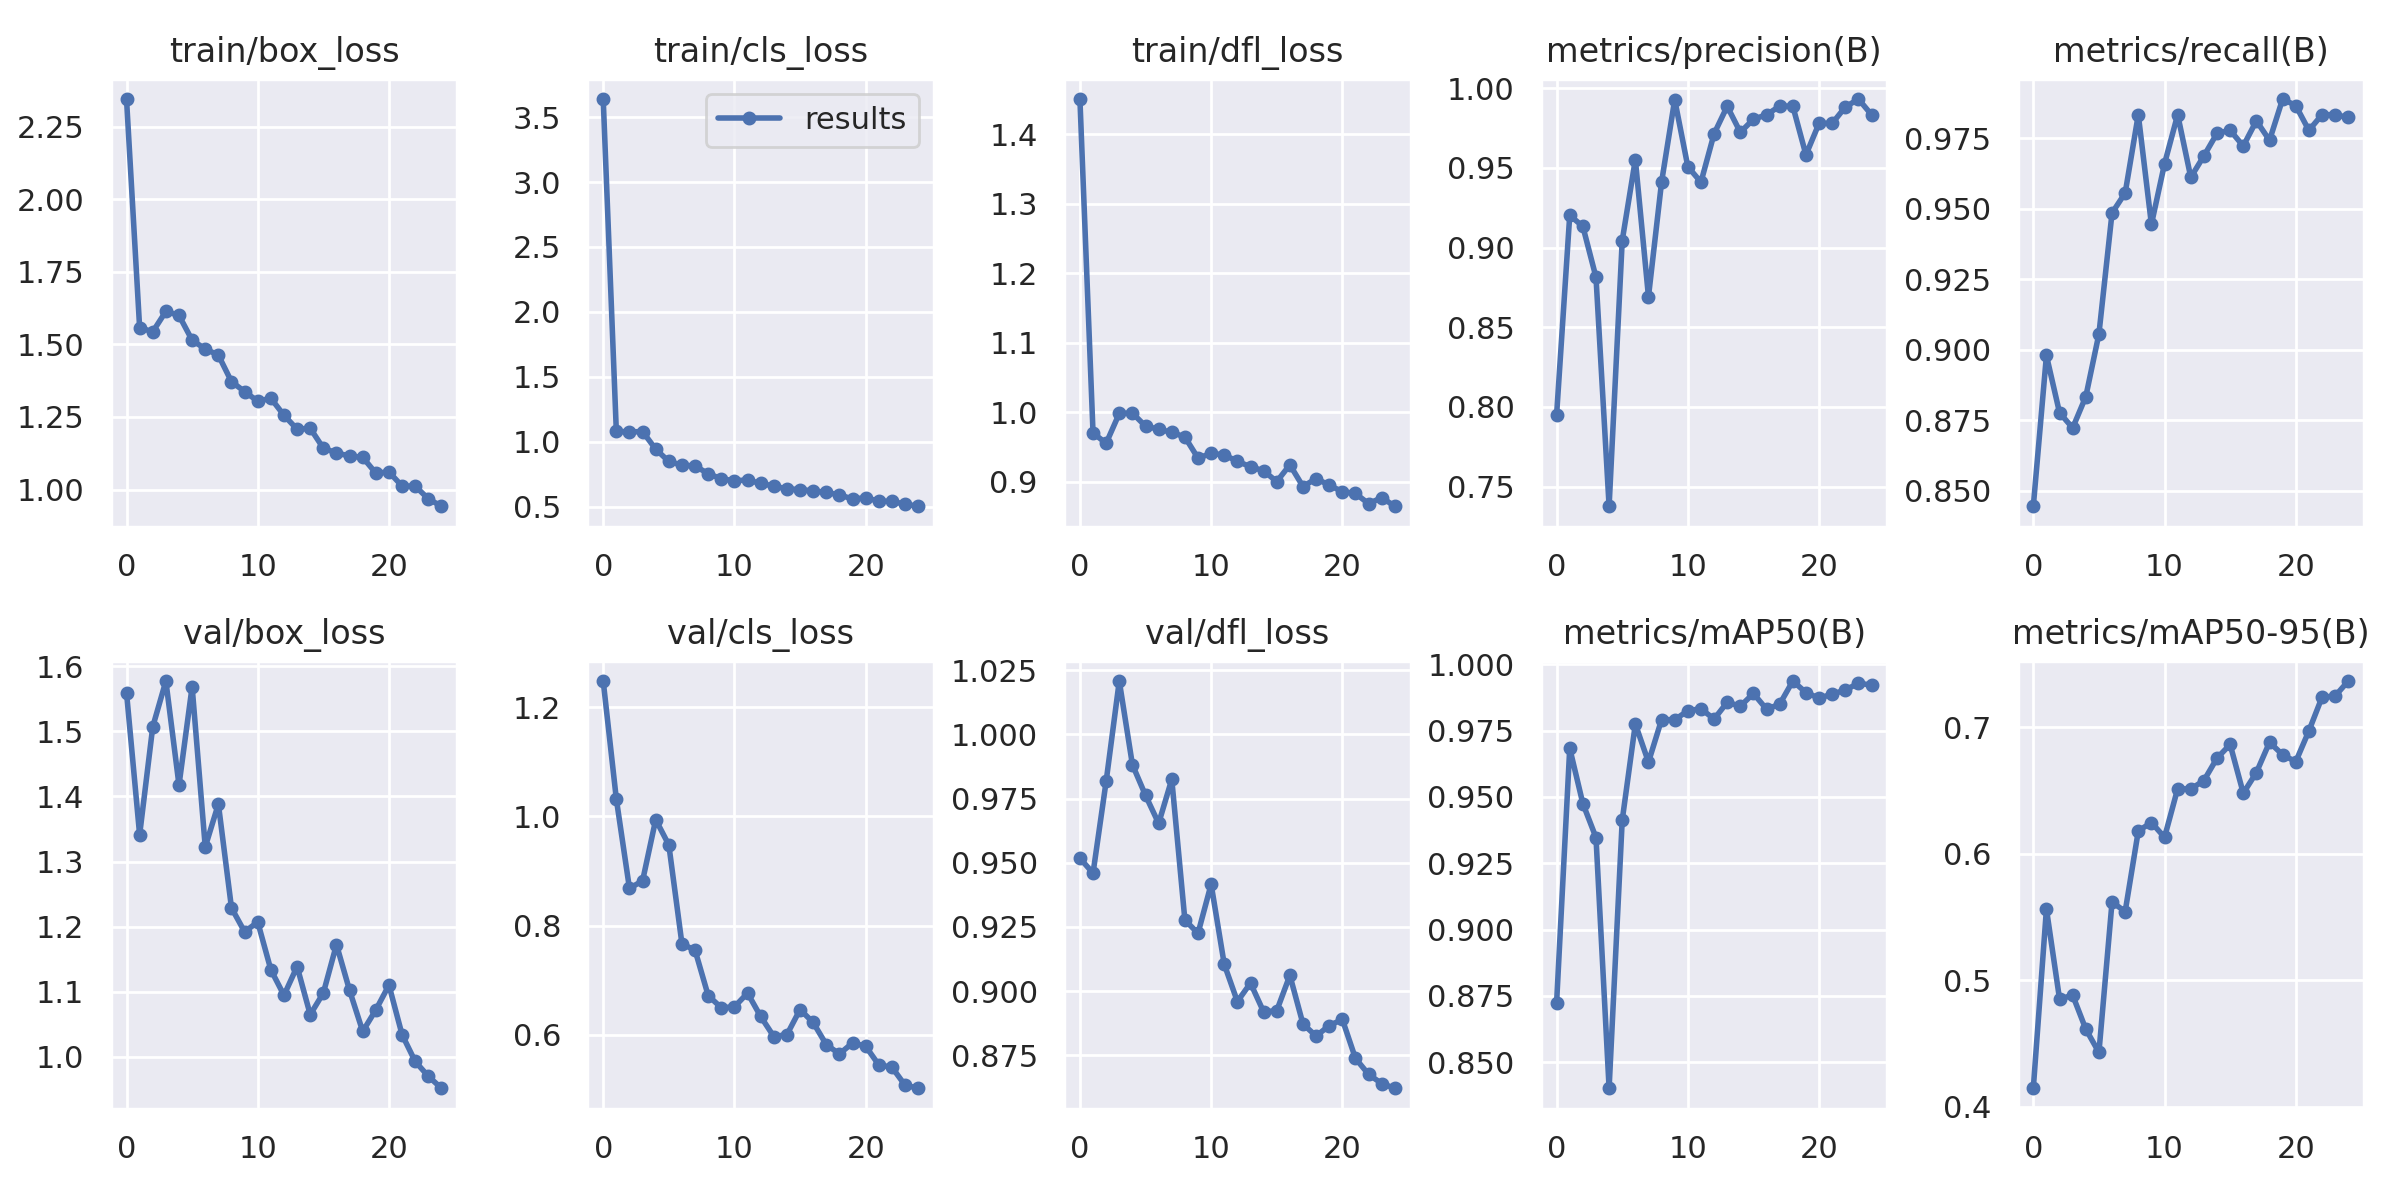

In [ ]:
Image(filename='/content/drive/MyDrive/yolov8/runs/detect/train9/results.png', width=600)

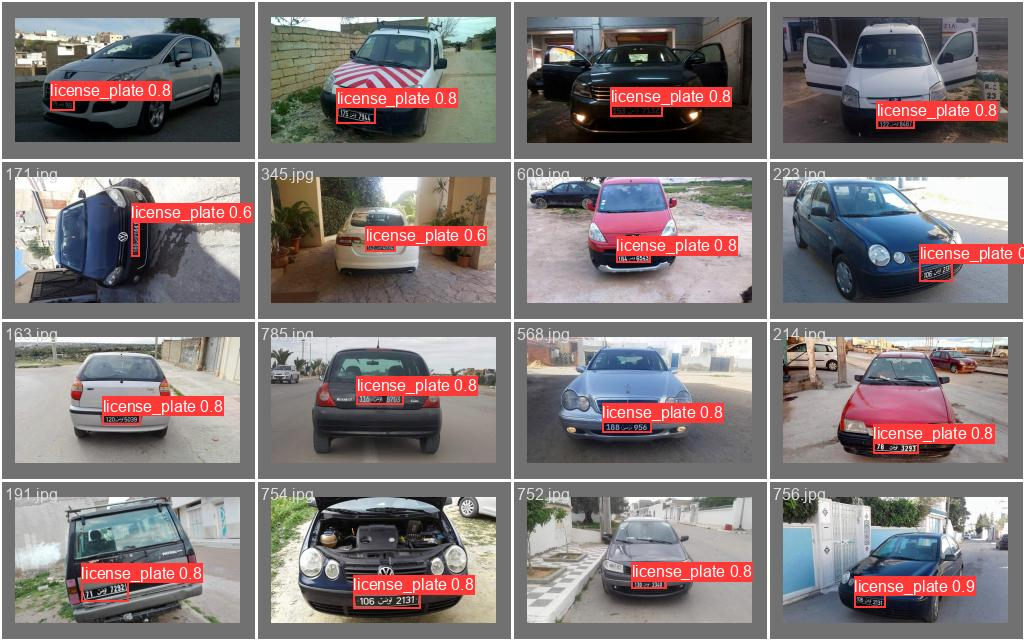

In [ ]:
Image(filename='/content/drive/MyDrive/yolov8/runs/detect/train9/val_batch0_pred.jpg', width=600)

## Validate Custom Model

In [ ]:
import easyocr
import cv2
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO



# Load the trained YOLOv8 model
model = YOLO("/content/drive/MyDrive/yolov8/runs/detect/train9/weights/best.pt")  # Use the path to your trained model

def detect_and_extract_text(image_path):
    # Perform inference with YOLOv8 model
    results = model(image_path)

    # Load the original image
    img = cv2.imread(image_path)
    if img is None:
        raise Exception(f"Failed to load image: {image_path}")

    # List to store extracted texts
    extracted_texts = []

    # Iterate over detected bounding boxes
    for result in results[0].boxes:  # Access the first image results
        # Extract bounding box coordinates
        xyxy = result.xyxy[0]  # Get the bounding box coordinates

        xmin = int(xyxy[0])
        ymin = int(xyxy[1])
        xmax = int(xyxy[2])
        ymax = int(xyxy[3])

        # Crop the detected region
        cropped_img = img[ymin:ymax, xmin:xmax]

        # Convert to RGB (OpenCV loads images in BGR format)
        cropped_img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)

        # Perform OCR on the cropped image
        reader=easyocr.Reader(['en'])
        result=reader.readtext(cropped_img_rgb)
        extracted_texts.append(result)
        num="None"
        # Draw bounding box and add OCR result to the image
        try:
            new_txt=[]
            if len(extracted_texts[0]) > 1:
                for i in range(len(extracted_texts[0]),0,-1):
                    print(i)
                    new_txt.append(extracted_texts[0][-i][-2])
            else:
                new_txt.append(result[0][-2])
            num = " ".join(new_txt)
        except:
            print("An exception occurred")


        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(img, num, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    i=image_path.split('\\')

    # Convert image to RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with the bounding boxes and text
    print(result)
    print(i[-1])
    plt.imshow(img_rgb)
    cv2.imwrite(f"/content/drive/MyDrive/yolov8/images/licensePlate_detected image/{i[-1]}",img_rgb)
    plt.axis('off')  # Hide the axis
    plt.show()

    return extracted_texts

# Path to the image file

test_img_folder="/content/drive/MyDrive/license_plate_detector/test"
for filename in os.listdir(test_img_folder):
        img_path = os.path.join(test_img_folder, filename)
        print(img_path)
# Detect bounding boxes and extract text
        detect_and_extract_text(img_path)


